Autoreload notebook

In [1]:
%load_ext autoreload
%autoreload 2


In [53]:
import os
import warnings
import sys

import dvc.api
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from fast_ml.model_development import train_valid_test_split
from sklearn.tree import DecisionTreeClassifier
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
import logging

>> #### Import modules

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from ml import Ml
from preprocess import Preprocess

Instantiate preprocessing & ml class

In [4]:
ml = Ml()
preprocess = Preprocess()

In [5]:
# Gets or creates a logger
logger = logging.getLogger(__name__)
# set log level
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(f'../logs/decission_trees.log')
formatter = logging.Formatter(
    '%(asctime)s : %(levelname)s : %(name)s : %(message)s', '%m-%d-%Y %H:%M:%S')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [6]:
# Get URL from DVC
path = 'data/AdSmartABdata.csv'
repo = 'https://github.com/jedisam/abtest-mlops'
version = '6db449393c9626c4fbca44946dfa103660685a27'

In [7]:
# Load data from dvc using the dvc.api.Dataset class
data_url = dvc.api.get_url(
    path=path,
    repo=repo,
    rev=version
)

In [9]:
# Read CSV file from remote repository
data = pd.read_csv(data_url, sep=',')

Convert date column to datetime

In [10]:
# change the date column to datetime
data = preprocess.convert_to_datetime(data, 'date')

Get numerical & categorical features

In [11]:
numerical_column = preprocess.get_numerical_columns(data)
categorical_column = preprocess.get_categorical_columns(data)

Remove the id column

In [12]:
# drop auction_id from categorical_column
categorical_column.remove('auction_id')

In [13]:
# Get column names have less than 10 more than 2 unique values
to_one_hot_encoding = [col for col in categorical_column if data[col].nunique() <= 10 and data[col].nunique() > 2]

# Get Categorical Column names thoose are not in "to_one_hot_encoding"
to_label_encoding = [col for col in categorical_column if not col in to_one_hot_encoding]

Encode categorical features

In [14]:
# Label encoding
label_encoded_columns = preprocess.label_encode(data, to_label_encoding)

Select relevant rows

In [43]:
# Copy our DataFrame to X variable
X = data.copy()

# Droping Categorical Columns,
# "inplace" means replace our data with new one
# Don't forget to "axis=1"
X.drop(categorical_column, axis=1, inplace=True)

# Merge DataFrames
X = pd.concat([X, label_encoded_columns], axis=1)

In [44]:
# Select only rows with responses
X = X.query('yes == 1 | no == 1')

In [45]:
# Drop auction_id column
X.drop(["auction_id"], axis=1, inplace=True)

Split data

In [46]:
X['target'] = [1] * X.shape[0]
X.loc[X['no'] == 1, 'target'] = 0
y = X['target']
X.drop(["target"], axis=1, inplace=True)
X.drop(['yes', 'no'], axis=1, inplace=True)

In [47]:
# Get the day of the week from the date column as a new column
X['day'] = X['date'].dt.dayofweek
X.drop(["date"], axis=1, inplace=True)

>> ### Decision Tree Classifier

In [54]:
decision_tree_model = DecisionTreeClassifier(criterion="entropy",
                                     random_state=0)
decision_tree_result = ml.cross_validation(decision_tree_model, X, y, 5)

Plot accuacy results

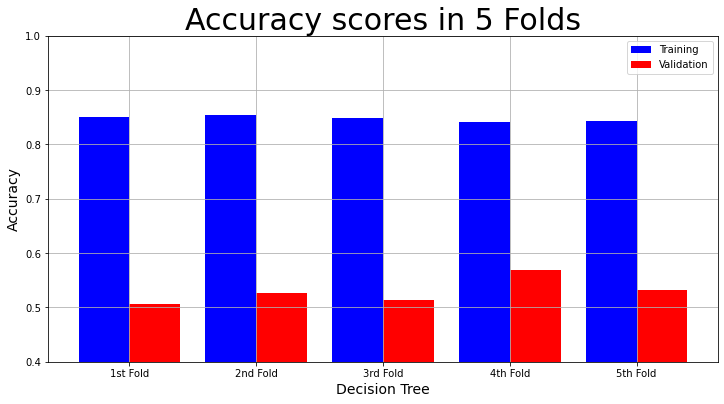

In [55]:
# Plot Accuracy Result
model_name = "Decision Tree"
ml.plot_result(model_name, "Accuracy", "Accuracy scores in 5 Folds", decision_tree_result["Training Accuracy scores"], decision_tree_result["Validation Accuracy scores"])

Precision Results

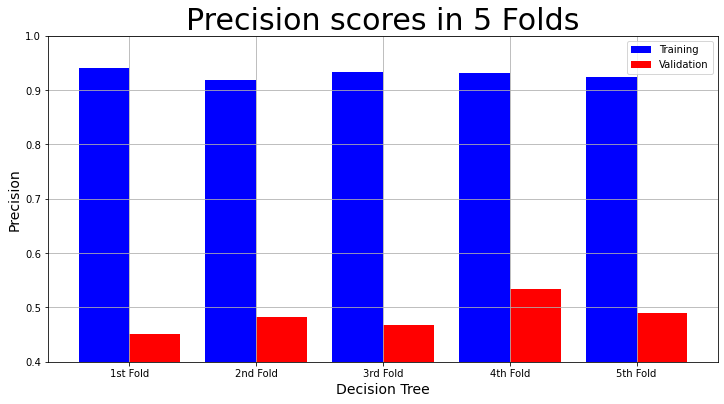

In [56]:
# Plot Precision Result
ml.plot_result(model_name, "Precision", "Precision scores in 5 Folds", decision_tree_result["Training Precision scores"], decision_tree_result["Validation Precision scores"])

Recall Results plot

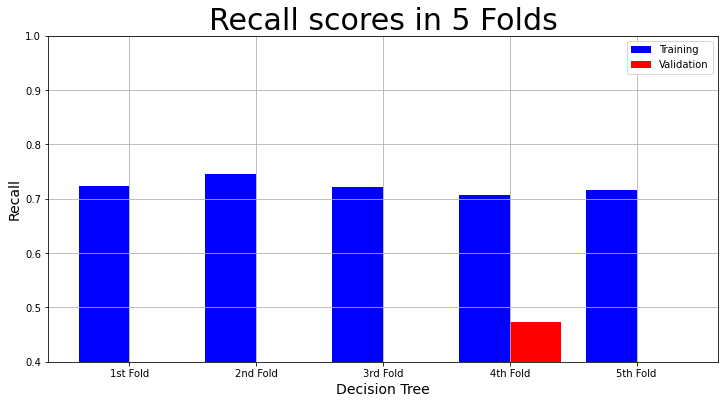

In [57]:
# Plot Recall Result
ml.plot_result(model_name, "Recall", "Recall scores in 5 Folds", decision_tree_result["Training Recall scores"], decision_tree_result["Validation Recall scores"])


F1 Score Results

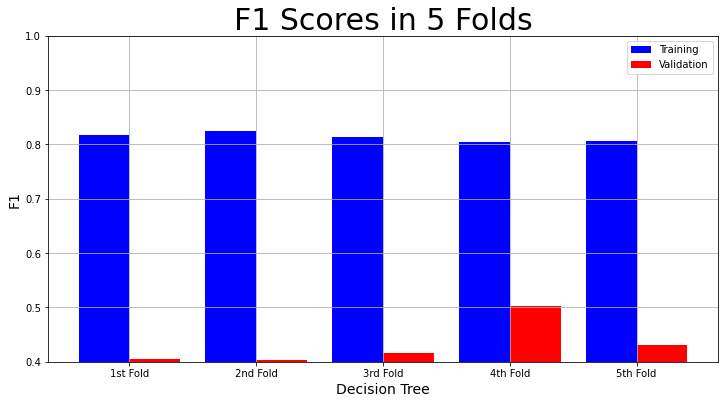

In [58]:
# Plot F1-Score Result
ml.plot_result(model_name, "F1", "F1 Scores in 5 Folds", decision_tree_result["Training F1 scores"], decision_tree_result["Validation F1 scores"])

The model is overfitting as it is working well on the training data but not on the validation set.
We will adjust the min_samples_split hyperparameter to fix this.

In [63]:
# Fine tunin the min_samples_split parameter
decision_tree_model_2 = DecisionTreeClassifier(criterion="entropy",
                                               min_samples_split=4,
                                               random_state=0)
decision_tree_result_2 = ml.cross_validation(decision_tree_model_2, X, y, 5)

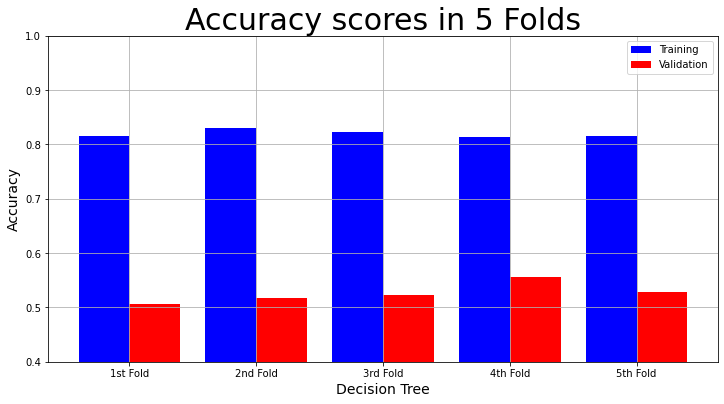

In [64]:
# Plot Accuracy Result
ml.plot_result(model_name, "Accuracy", "Accuracy scores in 5 Folds", decision_tree_result_2["Training Accuracy scores"], decision_tree_result_2["Validation Accuracy scores"])

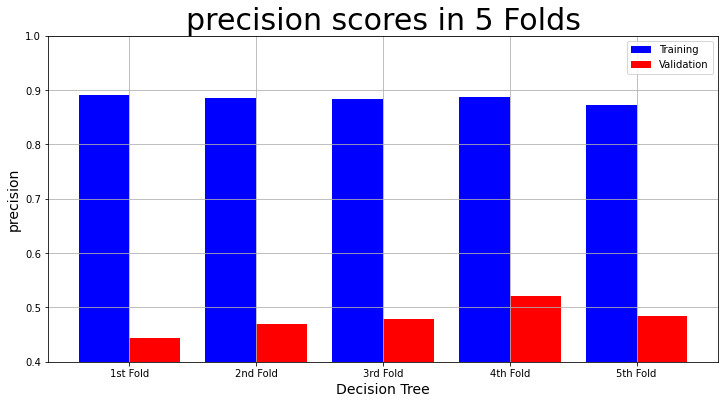

In [65]:
# Plot Precision Result
ml.plot_result(model_name, "precision", "precision scores in 5 Folds", decision_tree_result_2["Training Precision scores"], decision_tree_result_2["Validation Precision scores"])

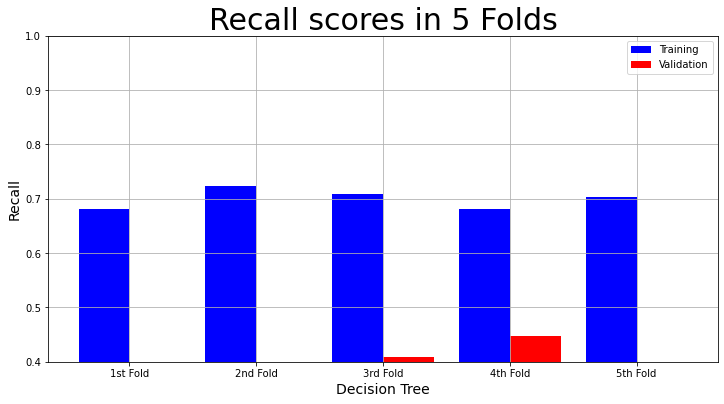

In [66]:
# Plot Recall Result
ml.plot_result(model_name, "Recall", "Recall scores in 5 Folds", decision_tree_result_2["Training Recall scores"], decision_tree_result_2["Validation Recall scores"])

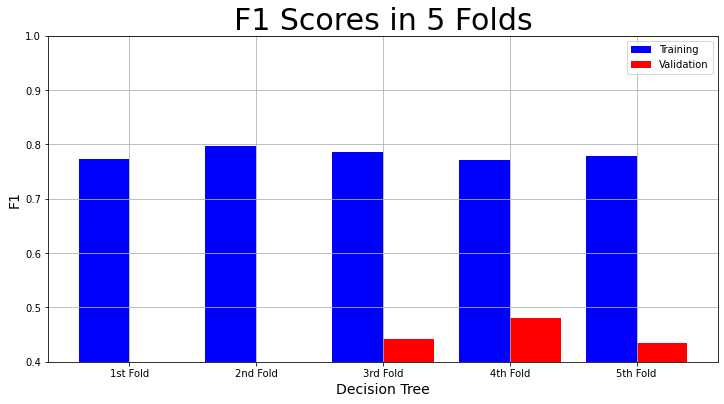

In [67]:
# Plot F1-Score Result
ml.plot_result(model_name, "F1", "F1 Scores in 5 Folds", decision_tree_result_2["Training F1 scores"], decision_tree_result_2["Validation F1 scores"])